*Chapter 15 – Processing Sequences Using RNNs and CNNs**

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Basic RNNs

### Generate the Dataset

In [4]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


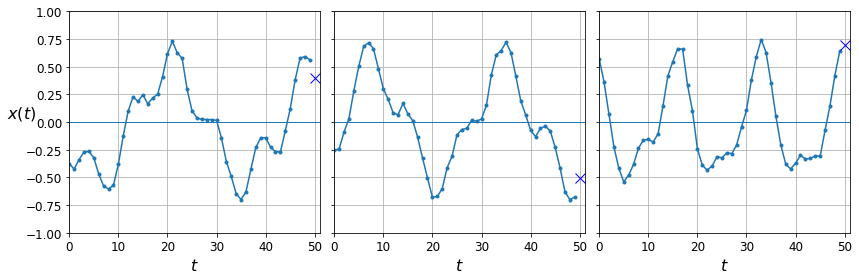

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines
Naive predictions (just predict the last observed value):

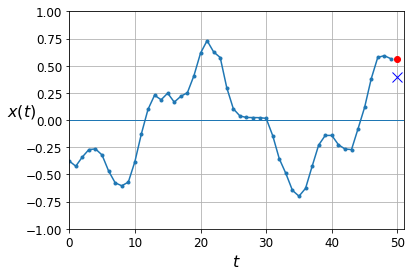

In [8]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 1s 2ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/10
219/219 [==============================] - 0s 676us/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/10
219/219 [==============================] - 0s 609us/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/10
219/219 [==============================] - 0s 631us/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/10
219/219 [==============================] - 0s 616us/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/10
219/219 [==============================] - 0s 627us/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/10
219/219 [==============================] - 0s 649us/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/10
219/219 [==============================] - 0s 636us/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/10
219/219 [==============================] - 0s 616us/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/10
219/219 [==============================] - 0s 616us/step - loss: 0.0063 

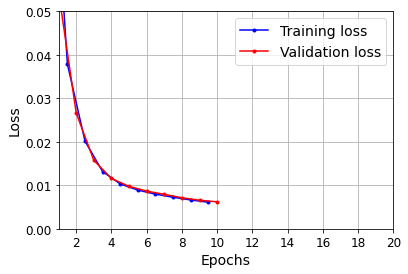

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

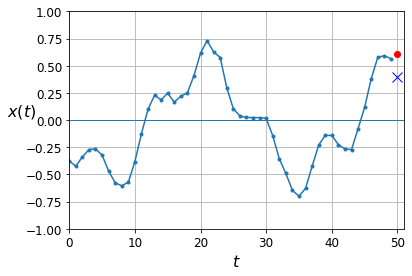

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 2s 6ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0110

63/63 [==============================] - 0s 2ms/step - loss: 0.0110


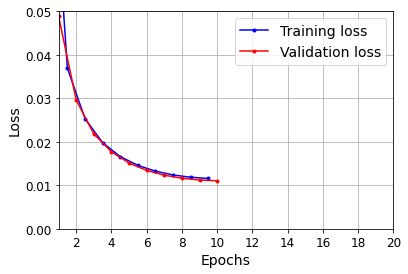

In [13]:
model.evaluate(X_valid, y_valid)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

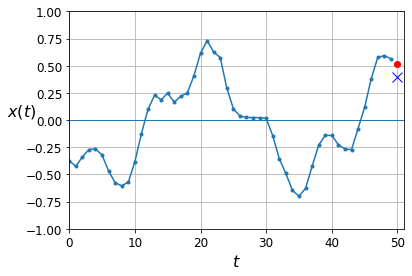

In [14]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 6s 21ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/10
219/219 [==============================] - 4s 20ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0035 - val_lo

63/63 [==============================] - 0s 5ms/step - loss: 0.0031


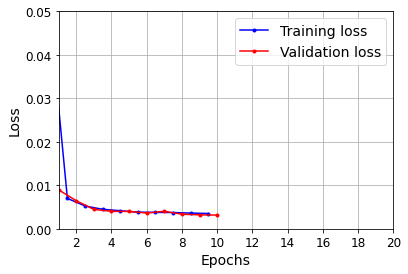

In [17]:
model.evaluate(X_valid, y_valid)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

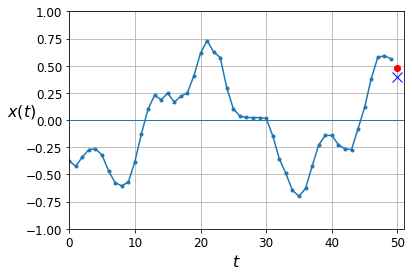

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [21]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


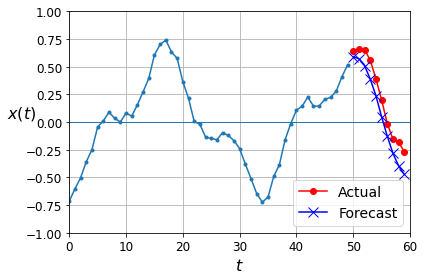

In [22]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [24]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
Y_pred.shape

(2000, 10)

In [25]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.03635959

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [26]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848